In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt

from pose_estimation.icp import icp
from pose_estimation.pose_data_class import PoseData, PoseDataset, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte

WORKDIR = f"{os.getcwd()}/.."

MODELS_PATH = os.path.join(WORKDIR, "models")

TRAIN_PATH = os.path.join(WORKDIR, "training_data")
TEST_PATH = os.path.join(WORKDIR, "testing_data")

TRAIN_SPLIT_PATH = os.path.join(TRAIN_PATH, "splits", "v2", "train.txt")
VAL_SPLIT_PATH = os.path.join(TRAIN_PATH, "splits", "v2", "val.txt")


In [2]:
source_banana = trimesh.load(f"{WORKDIR}/banana.source.ply").vertices
target_banana = trimesh.load(f"{WORKDIR}/banana.target.ply").vertices
gt_banana = np.loadtxt(f"{WORKDIR}/banana.pose.txt")

RUN_ICP_SANITY = False
if RUN_ICP_SANITY:
    iterations = 20
    attempts = 10
    # Visualization
    T = icp(source_banana, target_banana, attempts=10)
    rre = np.rad2deg(compute_rre(T[:3, :3], gt_banana[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_banana[:3, 3])
    print(f"rre={rre}, rte={rte}")
    compare_points(source_banana @ T[:3, :3].T + T[:3, 3], target_banana)


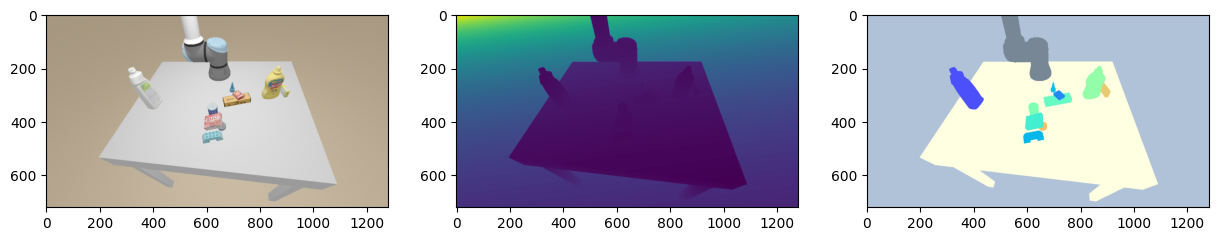

In [3]:

all_data = PoseData(TRAIN_PATH, MODELS_PATH)
# train_data = all_data.txt_split(TRAIN_SPLIT_PATH)
# mesh = train_data.get_mesh(35)
# mesh.show()
data = all_data

scene = data[2, 1, 4]

rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation


3033
[[ 0.82950458  0.55839879 -0.01062738  0.09975974]
 [-0.55843908  0.8295449  -0.00102561  0.00209405]
 [ 0.00824319  0.0067855   0.999943    0.01556345]
 [ 0.          0.          0.          1.        ]]
[[ 8.2932293e-01  5.5869412e-01 -9.1853868e-03  9.9549852e-02]
 [-5.5872190e-01  8.2935488e-01 -5.6099193e-04  2.0669431e-03]
 [ 7.3045227e-03  5.5973204e-03  9.9995768e-01  1.5168296e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

rre=0.08833174043017915, rte=0.0004482580990880307


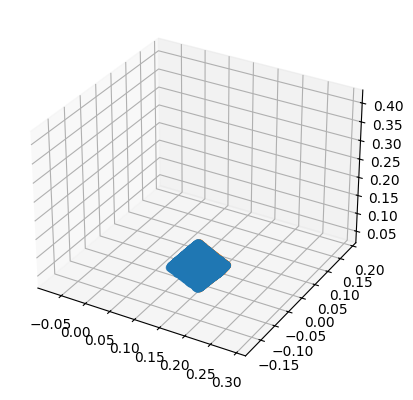

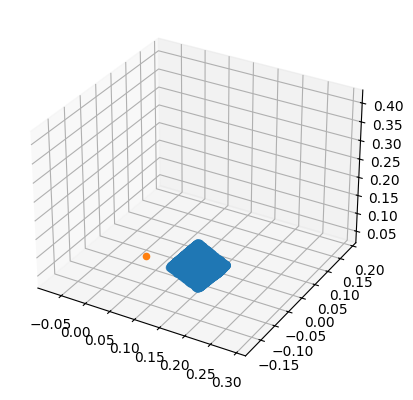

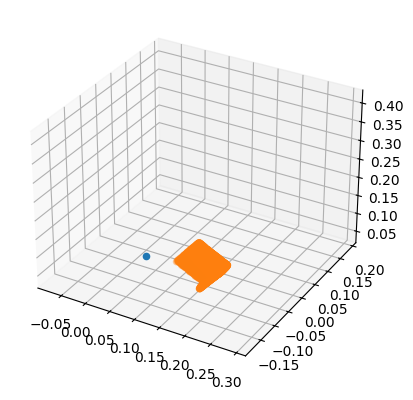

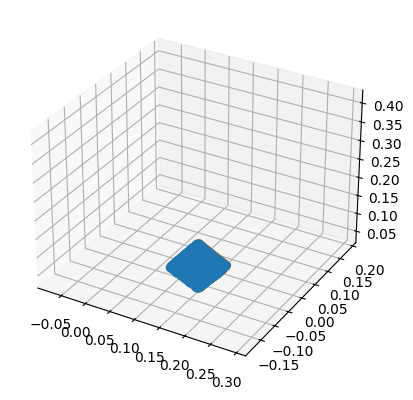

In [4]:
selection = 2, 5, 6
scene = data[selection]

rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

back_projection = back_project(depth, meta, world=True)

item = 4
obj_id = meta["object_ids"][item]

indices = np.where(label == obj_id)
obj_pnts = back_projection[indices]
obj_rgb = rgb[indices]

NUM_POINTS = len(obj_pnts)
print(NUM_POINTS)
SAMPLES = NUM_POINTS # NUM_POINTS # 20_000

mesh = data.get_mesh(obj_id)
source_pcd, faces = trimesh.sample.sample_surface(mesh, SAMPLES)

source_pcd = source_pcd # * meta["scales"][obj_id]
target_pcd = obj_pnts / meta["scales"][obj_id] # Back Projected

scale = 0.1
translate = np.mean(obj_pnts, axis=0)

attempts = 10
# Visualization
T = icp(source_pcd, target_pcd, attempts=attempts)

print(T)
gt_T = meta["poses_world"][obj_id]
print(gt_T)
print("")

rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
rte = compute_rte(T[:3, 3], gt_T[:3, 3])
print(f"rre={rre}, rte={rte}")

compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd, scale=scale, translate=translate)

# These are individual plots and will also point at the origin (stray points)
compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], np.zeros((1, 3)), scale=scale, translate=translate)
compare_points(np.zeros((1, 3)), target_pcd, scale=scale, translate=translate)

compare_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], target_pcd,  scale=scale, translate=translate)


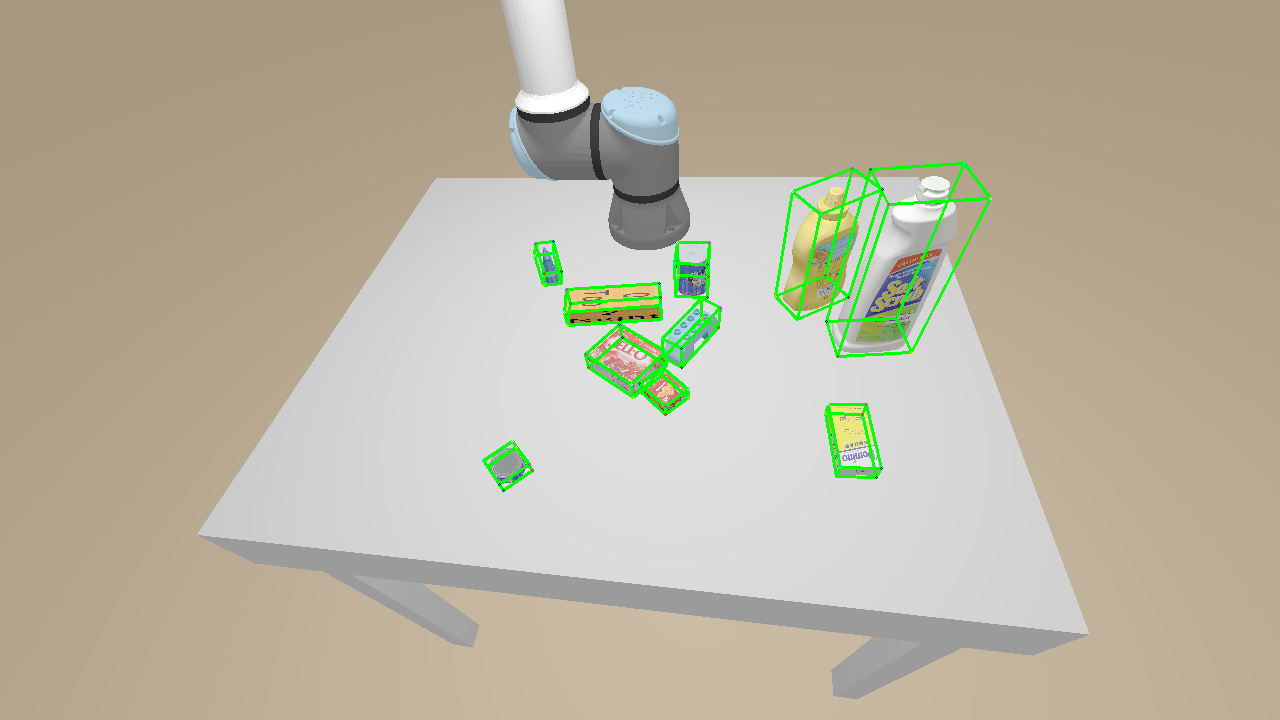

In [8]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))


In [ ]:
data = PoseData(TEST_PATH, MODELS_PATH)

MESH_SAMPLES = None
ICP_ATTEMPTS = 10

results = {}
print(len(data))
for i, key in enumerate(data.keys()):

    print(i, key)

    l, s, v = key

    scene = data[key]

    rgb = scene["color"]()
    depth = scene["depth"]()
    label = scene["label"]()
    meta = scene["meta"]
    
    back_projection = back_project(depth, meta)

    world_frames = [None] * 79

    object_ids = [object_id for object_id in np.unique(label) if object_id < 79]

    for object_id in object_ids:

        indices = np.where(label == object_id)
        obj_pnts = back_projection[indices]
        obj_rgb = rgb[indices]

        mesh = data.get_mesh(object_id)
        source_pcd, faces = trimesh.sample.sample_surface(mesh, len(obj_pnts) if MESH_SAMPLES in [-1, 0, None, False] else MESH_SAMPLES)

        source_pcd = source_pcd * meta["scales"][object_id]
        target_pcd = obj_pnts

        T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

        world_frames[object_id] = T.tolist()

        results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


200
0 (1, 19, 1)
1 (2, 88, 1)
2 (1, 85, 1)
3 (1, 72, 1)
4 (1, 45, 1)
5 (1, 20, 1)
6 (1, 88, 1)
7 (1, 14, 1)
8 (2, 63, 1)
9 (1, 77, 1)
10 (1, 10, 1)
11 (1, 43, 1)
12 (1, 27, 1)
13 (2, 14, 1)
14 (1, 2, 1)
15 (2, 20, 1)
16 (1, 57, 1)
17 (2, 43, 1)
18 (2, 15, 1)
19 (1, 34, 1)
20 (2, 77, 1)
21 (2, 22, 1)
22 (2, 85, 1)
23 (2, 19, 1)
24 (1, 91, 1)
25 (1, 39, 1)
26 (2, 40, 1)
27 (2, 10, 1)
28 (1, 67, 1)
29 (1, 59, 1)
30 (1, 6, 1)
31 (1, 53, 1)
32 (1, 98, 1)
33 (2, 94, 1)
34 (1, 30, 1)
35 (2, 7, 1)
36 (2, 73, 1)
37 (1, 7, 1)
38 (1, 95, 1)
39 (1, 29, 1)
40 (1, 81, 1)
41 (2, 95, 1)
42 (1, 24, 1)
43 (2, 53, 1)
44 (2, 67, 1)
45 (1, 47, 1)
46 (2, 98, 1)
47 (2, 30, 1)
48 (2, 91, 1)
49 (2, 39, 1)
50 (1, 80, 1)
51 (2, 34, 1)
52 (2, 18, 1)
53 (2, 57, 1)
54 (2, 3, 1)
55 (1, 63, 1)
56 (1, 48, 1)
57 (2, 47, 1)
58 (2, 51, 1)
59 (2, 66, 1)
60 (2, 24, 1)
61 (2, 33, 1)
62 (2, 29, 1)
63 (2, 81, 1)
64 (1, 36, 1)
65 (2, 1, 1)
66 (1, 73, 1)
67 (1, 54, 1)
68 (2, 99, 1)
69 (2, 9, 1)
70 (2, 49, 1)
71 (1, 18, 1)
72 (1

In [ ]:
pose_dataset = PoseDataset(TRAIN_PATH, MODELS_PATH)


NameError: name 'PoseDataset' is not defined

In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f)
